#### OBJECTIVES

1. pull information going back to 2000
2. breakdown port allocations in key reusable methods
3. implement date rules to perform optimization at given intervals (date resample)
4. calculate cumulative portfolio returns as portfolio allocation changes
5. run sensitivities fine-tunning opt parameters (MVO day window, pos sizing, leverage)

#### Helper Methods

In [ ]:
from datetime import datetime, date, time, timedelta
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os

pattern = r'holdings-'
path = "./sector_components/"
date_fmt = '%m-%d-%Y'

ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy_sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE']
}

sectors = ticker_map['spy_sectors']
sector_tickers_map = {}

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
key = list(ticker_map.keys())[3]
print("retrieving prices for:", key, ticker_map[key])

In [ ]:
def get_pricing(ticker_list, start_date):
    px = web.DataReader(ticker_list,data_source='yahoo',start=start_date)['Adj Close']
    px.to_csv(key + '_prices.csv')
    return px

compound = lambda x: (x + 1).cumprod()
two_dec = lambda x: '%.4f' % x
def show_weights(weights, labels, ret, sigma):
    df = pd.DataFrame(weights, columns=labels)
    df['return'] = ret * 252
    df['sigma'] = sigma * np.sqrt(252)
    df['sharpe'] = df['return'] / df['sigma']
    return df

In [ ]:
def get_mean_variance(rets):
    w_len = rets.shape[1]
    eq_weights = np.asarray([1/w_len for _ in range(w_len)])
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values

In [ ]:
def get_mvo_allocations(n, mean_returns, cov_matrix, alloc_sum=1, min_w=0, max_w=0.2):
    mu = mean_returns.T
    Sigma = cov_matrix
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(w) == alloc_sum, 
         w > min_w,
         w < max_w])
    gamma.value = 0.5; prob.solve()
    if prob.status == 'optimal': return [i[0] for i in w.value.tolist()]

In [ ]:
def calc_port_performance(arr, weights, lag=0):
    #caculate portfolio returns
    #m_mult = np.cumprod((arr + 1),axis=0) * weights # returns array * weights
    #return np.sum(m_mult, axis=1)
    return np.cumprod(np.sum(arr * weights, axis=1) + 1)

def date_rules(date_range, tgt_date_str, freq):
    #return a list of dates
    tgt_dt = datetime.strptime(tgt_date_str, date_fmt)
    return date_range[:date_range.index(tgt_dt)+1][::-freq]

def date_intervals(df, freq):
    return df.resample(freq, closed='left', label='left').mean()

#### Test Methods

In [ ]:
np.random.seed(42)
numdays, cols = 100, 10
end_date_str, tgt_date_str = '12-31-2017', '12-27-2017'
freq = 7; lookback = 20

arr = (np.random.rand(numdays, cols) - 0.5) / 10
weights = np.random.rand(1, cols)
weights = weights / np.sum(weights, axis=1).T

In [ ]:
#test the portfolio performance calculation
port_perf = calc_port_performance(arr, weights)
#pd.DataFrame(port_perf).plot()
port_perf

In [ ]:
#test the date rules / intervals
end_date = datetime.strptime(end_date_str, date_fmt)
d_rng = sorted([end_date - timedelta(x) for x in range(0, numdays)]) # using list comprenhensions
sorted(date_rules(d_rng, tgt_date_str, freq))

d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))
intervals = list(sorted(date_rules(d_rng, tgt_date_str, freq)))
print("check:", len(intervals), "equals", numdays // freq, "result:",len(intervals) == numdays // freq) # check if intervals works
intervals[-5:]

In [ ]:
d_rng = pd.date_range(end=end_date_str, freq='D', periods=numdays) # using pandas date range
d_rng = list(pd.to_datetime(d_rng))

df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
(df+1).cumprod().mean(axis=1).plot()

In [ ]:
#test both the portfolio performance using date intervals without optimization / equal weights
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    #lb_returns = df.loc[:i.date()].tail(lookback)
    weights = np.array([1/cols for _ in range(cols)])
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')

port_perf = calc_port_performance(df.values, hist_alloc.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
#test both the portfolio performance using date intervals with optimization
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_alloc = pd.DataFrame(np.zeros((len(df),cols)), index=df.index)

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(n, mean_returns, cov_matrix, min_w=0.0, max_w=0.3)
    #print(['{0:.2f}'.format(x) for x in weights])
    hist_alloc.loc[i.date()] = weights

hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
hist_alloc

port_perf = calc_port_performance(df.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf)
pdf.plot()
port_perf[-1:]

#### Load ETF Holdings from CSV

In [ ]:
flist = os.listdir(path)
files = [f for f in flist if f.startswith(pattern)]
colstoload = ['Symbol','Company Name', 'Index Weight']
companies = pd.DataFrame([])

for s in sectors:
    fname = path + pattern + s.lower() + '.csv'
    df = pd.read_csv(fname, skiprows=1, index_col='Symbol', usecols=colstoload)
    df['ETF'] = s
    sector_tickers_map[s] = df.index.tolist()
    companies = companies.append(df)
print("Company Sample:")
companies.shape
#companies[::int(len(companies)*.1)]
#companies.groupby('ETF').count()
#for k in sector_tickers_map.keys(): print(k, sector_tickers_map[k])

#### Process (TBD)

In [22]:
numdays, cols = 252, 10; freq = 5; lookback = 20; hist_window = 252*5
end_date_str = tgt_date_str = '1-3-2018'
start_date = datetime.strptime('1-3-2018', date_fmt)
start_date = start_date - timedelta(hist_window)
dwld_key = 'XLK'

tickers = sector_tickers_map[dwld_key] # HITS THE SERVER: downloads data from yahoo for all tickers for a given sector
px = get_pricing(tickers, start_date.strftime(date_fmt))
px.to_csv(dwld_key + '-hold-pricing.csv')

In [23]:
# LOAD FROM HARD DRIVE
px = pd.read_csv(dwld_key + '-hold-pricing.csv', index_col='Date', parse_dates=True)

In [ ]:
# HITS THE SERVER: downloads data from yahoo for selected EFT
spyder_etf = get_pricing(dwld_key, start_date.strftime(date_fmt))
spyder_etf.name = dwld_key + ' ETF Index'
s_etf = (spyder_etf.pct_change() + 1).cumprod()

In [42]:
def get_perf_ts(dwld_key, px, freq, lb, w):
    #test both the portfolio performance using date intervals with optimization
    px.dropna(axis=1, inplace=True)
    returns = px.sort_index().pct_change()
    date_range = list(returns.index)
    intervals = list(sorted(date_rules(date_range, tgt_date_str, freq))) #old approach
    #intervals = date_intervals(returns, "W-Wed").index.tolist()
    #[x.strftime('%w %m %d %Y') for x in intervals]
    cols = returns.columns
    hist_alloc = pd.DataFrame(np.zeros((len(px),len(cols))), index=px.index, columns=cols)
    print('{0:d} stocks, {1:d} trading days, {2:d} lookback'.format(len(cols), len(px), lookback))
    
    for x, i in enumerate(intervals):
        lb_returns = returns.loc[:i.date()].tail(lookback).dropna()
        weights = np.array([0 for _ in range(len(cols))])
        if (len(lb_returns) > 2):
            n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
            #print(n, mean_returns, cov_matrix)
            weights = get_mvo_allocations(n, mean_returns, cov_matrix, max_w=w) # max exposure of X
            #print(['{0:.2f}'.format(x) for x in weights])
        #print(i.date(), np.sum(weights))
        hist_alloc.loc[i.date()] = weights
    r_clean = returns.dropna()
    hist_alloc = hist_alloc.loc[r_clean.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.fillna(0, inplace=True)
    print(r_clean.shape, hist_alloc.shape)
    port_perf = calc_port_performance(r_clean.values, hist_alloc.values)
    pdf = pd.DataFrame(port_perf, index=r_clean.index, columns=[dwld_key + '_optimized'])
    return pdf, r_clean, hist_alloc

In [43]:
pdf, r_clean, hist_alloc = get_perf_ts(dwld_key, px, freq, 20, 0.1)

67 stocks, 873 trading days, 20 lookback
(872, 67) (872, 67)


NameError: name 's_etf' is not defined

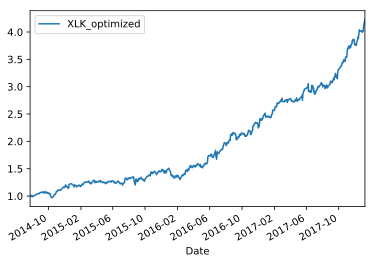

In [44]:
ax = pdf.plot()
s_etf.plot(ax=ax, legend='right')

In [45]:
from math import *
days = len(pdf)
ret = pdf.pct_change().mean() * (252)
std = pdf.pct_change().std() * sqrt(252)
print("days:", days, "return:", ret, "std dev:", std)
ret / std

days: 872 return: XLK_optimized    0.433674
dtype: float64 std dev: XLK_optimized    0.180684
dtype: float64


XLK_optimized    2.400179
dtype: float64

In [ ]:
#r_clean[::int(len(r_clean)*.1)].sum(axis=1)
#hist_alloc[::int(len(r_clean)*.1)].sum(axis=1)
(r_clean * hist_alloc).sum(axis=1).hist(bins=50)

In [ ]:
#hist_alloc.loc[::int(len(hist_alloc)*0.1)].plot(kind='hist')
top_allocs = hist_alloc.loc[pd.to_datetime(intervals)].sum(axis=0).sort_values(ascending=False)
top_allocs[:10], top_allocs[-10:]

In [ ]:
names = top_allocs[:10].index.tolist()

In [ ]:
#show behaviour during sepcific time window
pdf.loc['2016-1-1':'2016-3-31'].plot()
#pdf.loc['2016-1-1':'2016-3-31',top_allocs[:10].columns].plot()

#### Sequential optimization

In [ ]:
for x, i in enumerate(intervals):
    lb_returns = returns.loc[:i.date()].tail(lookback).dropna()
    weights = np.array([0 for _ in range(len(cols))])
    if (len(lb_returns) > 2):
        n, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
        #print(n, mean_returns, cov_matrix)
        weights = get_mvo_allocations(n, mean_returns, cov_matrix, max_w=0.1) # max exposure of X
        #print(['{0:.2f}'.format(x) for x in weights])
    #print(i.date(), np.sum(weights))
    hist_alloc.loc[i.date()] = weights
#hist_alloc.loc[intervals[0]:] = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
#hist_alloc = hist_alloc.loc[intervals[0]:].replace(0, np.nan).fillna(method='ffill')
#hist_alloc.fillna(0, inplace=True)
r_clean = returns.dropna()
hist_alloc = hist_alloc.loc[r_clean.index].replace(0, np.nan).fillna(method='ffill')
hist_alloc.fillna(0, inplace=True)

In [ ]:
print(r_clean.shape, hist_alloc.shape)
#s = set(r_clean.index)
#s2 = set(hist_alloc.index)
#intersect_idx = s.intersection(s2)
#hist_alloc.loc[list(intersect_idx)].sort_index()
#hist_alloc.sum(axis=1)

In [ ]:
port_perf = calc_port_performance(r_clean.values, hist_alloc.values)
pdf = pd.DataFrame(port_perf, index=r_clean.index, columns=[dwld_key + '_optimized'])

#### Old Scripts

In [ ]:
for s in sector_tickers_map.keys():
    print(len(sector_tickers_map[s]))
    
#test both the portfolio performance using date intervals with optimization
df = pd.DataFrame(arr, index=d_rng, columns=[i for i in range(cols)])
date_range = list(df.index)
intervals = list(sorted(date_rules(date_range, tgt_date_str, freq)))
hist_allocations = pd.DataFrame(np.zeros((len(intervals),cols)), index=pd.to_datetime(intervals))

for i in intervals:
    lb_returns = df.loc[:i.date()].tail(lookback)
    w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(lb_returns)
    weights = get_mvo_allocations(mean_returns, cov_matrix)
    hist_allocations.loc[i.date()] = weights

port_perf = calc_port_performance(df.loc[intervals].values, hist_allocations.values)
pd.DataFrame(port_perf).plot()
port_perf[-1:]

In [ ]:
px = get_pricing(ticker_map[key], '01/01/2017')
returns = px.sort_index().pct_change()
compound(returns).plot()

In [ ]:
w_len, weights, mean_returns, std_dev, cov_matrix = get_mean_variance(returns)

ann_returns = np.dot((mean_returns * 252), weights)
ann_stdev = np.sqrt(252/len(returns)) * std_dev
print(weights.shape, cov_matrix.shape)
port_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
print("eq weight return(exp)", ann_returns)
print("port risk(exp):", port_variance)
print("sharpe ratio:", ann_returns / port_variance)

In [ ]:
# Long only portfolio optimization.
weights = get_mvo_allocations(mean_returns, cov_matrix)
np_weights = np.array([weights]).T
exp_return = np.dot(np.array([mean_daily_returns.values]), np_weights) * 252
portfolio_std_dev = np.sqrt(np.dot(np_weights.T, np.dot(cov_matrix, np_weights))) * np.sqrt(252)
print("optimized return(exp):", exp_return)
print("optimized portfolio risk(exp):", portfolio_std_dev)
print("sharpe ratio:", exp_return / portfolio_std_dev)

In [ ]:
# Compute trade-off curve.
SAMPLES = 100
weights = []
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    weights.append([i[0] for i in w.value.tolist()])
    risk_data[i] = cvx.sqrt(risk).value
    ret_data[i] = ret.value
print('Optimization status:', prob.status)
#w.value, risk_data, ret_data
#ret_data / risk_data # sharpe ratio
#risk_data[np.argmin(risk_data)], risk_data[np.argmax(ret_data)]
#wgt_cum_ret = (ret_data + 1).cumprod()
cols = returns.columns.tolist();
allocs = show_weights(weights, returns.columns, ret_data, risk_data); allocs.tail()
allocs[cols].plot()
print(allocs[-1:].apply(two_dec))

In [ ]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = range(1, 100, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    #ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker], ret_data[marker]))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
    ax.annotate(returns.columns[i], xy=(sqrt(Sigma[i,i]).value, mu[i]))
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [ ]:
gamma_vals.shape, risk_data.shape, ret_data.shape
summary = pd.DataFrame([], columns=['gamma', 'risk', 'return'], index=range(SAMPLES))
summary['gamma'] = np.array([gamma_vals]).T
summary['risk'] = np.array([risk_data]).T
summary['return'] = np.array([ret_data]).T
summary[['risk','return']].plot(kind='line')